# Análise da razão entre o valor total comprovado e captado de um projeto
---

Issue: [#201](https://github.com/lappis-unb/salic-ml/issues/201) Explorar nova métrica: razão entre o valor total comprovado e o valor total captado de um projeto.

## Objetivos

Analisar a razão entre o valor total comprovado e o valor total captado para todos os projetos culturais, sem delimitações de segmento ou produto cultural. Nesta análise, serão utilizados modelos para identificar projetos onde tal métrica é anormal com relação aos demais projetos.

A metodolgia e modelos aplicados neste notebook para identificar projetos considerados anômalos com relação a esta métrica é a mesma aplicada no notebook `notebooks/report/analysis_of_approved_funds.ipynb`, relativo à métrica "valor total aprovado para um projeto".

---
## Preparação

Será gerado um dataset contendo as informações abaixo relativas a cada projeto que tenha pelo menos um comprovante.
* Valor total aprovado
* Valor total captado
* Valor total comprovado
* Dados derivados dos itens acima

#### Importando módulos necessários

In [1]:
%pylab inline
import scipy
import pandas as pd
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


#### 1. Carregando dataset com o valor total captado por projeto

In [2]:
df_raised = pd.read_csv('../../data/raw/planilha_captacao.csv', low_memory=False)
print(df_raised.columns)
print(df_raised.shape)

Index(['Idcaptacao', 'Pronac', 'Segmento', 'NumeroRecibo', 'CgcCpfMecena',
       'TipoApoio', 'MedidaProvisoria', 'DtChegadaRecibo', 'DtRecibo',
       'CaptacaoReal', 'CaptacaoUfir', 'logon', 'isBemServico'],
      dtype='object')
(426036, 13)


#### Gerando dataset com o valor captado

In [3]:
raised = df_raised[['Pronac', 'CaptacaoReal']]
raised = raised.groupby(['Pronac']).sum()
raised = raised.sort_values(by='CaptacaoReal', ascending=False)
print(raised.shape)
raised.head()

(34330, 1)


,CaptacaoReal
Pronac,
107097,36255500.30
87684,35684235.27
88016,30660000.00
78984,29500000.00
108960,29500000.00


#### 2. Carregando dataset com o valor total comprovado

In [4]:
df_proven = pd.read_csv('../../data/raw/planilha_comprovacao.csv', low_memory=False)
print(df_proven.columns)
print(df_proven.shape)

Index(['PRONAC', 'idPlanilhaAprovacao', 'idComprovantePagamento', 'IdPRONAC',
       'idSegmento', 'cdProduto', 'cdEtapa', 'cdUF', 'UF', 'cdCidade',
       'idPlanilhaItem', 'Item', 'DataProjeto', 'nrComprovante', 'nrSerie',
       'nrCNPJCPF', 'nmFornecedor', 'proponenteCgcCpf', 'tpDocumento',
       'dtPagamento', 'dtEmissao', 'tpFormaDePagamento',
       'nrDocumentoDePagamento', 'idArquivo', 'dsJustificativaProponente',
       'dsOcorrenciaDoTecnico', 'stItemAvaliado', 'stAvaliacao',
       'vlComprovacao'],
      dtype='object')
(355664, 29)


#### Gerando dataset com o valor comprovado

In [5]:
proven = df_proven[['PRONAC', 'idComprovantePagamento', 'vlComprovacao']]
proven = proven.drop_duplicates(subset=['PRONAC', 'idComprovantePagamento'])
proven = proven.drop(columns=['idComprovantePagamento'])
proven = proven.groupby(['PRONAC']).sum()
proven = proven.sort_values(by='vlComprovacao', ascending=False)
print(proven.shape)
proven.head()

(2907, 1)


,vlComprovacao
PRONAC,
1410875,14577034.70
163824,14156633.49
158607,13912058.17
163306,11477852.20
164188,9758913.05


#### 3. Carregando dataset com o valor total aprovado

In [6]:
df_budget = pd.read_csv('../../data/raw/planilha_orcamentaria.csv')
print(df_budget.columns)
print(df_budget.shape)

Index(['idPronac', 'PRONAC', 'idPlanilhaAprovacao', 'Item', 'idPlanilhaItens',
       'Unidade', 'QtDias', 'QtItem', 'nrOcorrencia', 'VlUnitarioSolicitado',
       'VlTotalSolicitado', 'VlUnitarioAprovado', 'VlTotalAprovado', 'UfItem',
       'MunicipioItem', 'Etapa', 'idArea', 'Area', 'idSegmento', 'Segmento',
       'idProduto', 'Produto', 'DataProjeto', 'cdCidade', 'cdEtapa'],
      dtype='object')
(2026756, 25)


In [7]:
budget = df_budget[['PRONAC', 'VlTotalAprovado']]
budget = budget.groupby(['PRONAC']).sum()
budget = budget.sort_values(by='VlTotalAprovado', ascending=False)
print(budget.shape)
budget.head()

(41616, 1)


,VlTotalAprovado
PRONAC,
110515,91595529.00
129971,85896497.97
120499,64597555.67
120532,48684575.37
1210283,45399313.14


#### 4. Gerando dataset final com os valores captado e comprovado dos projetos

Neste passo, todos os projetos sem nenhum comprovante são descartados e todos os projetos com o valor de comprovação maior que o valor de captação também são descartados. É preciso investigar o porquê de isso acontecer. Uma hipótese é que o proponente pode comprovar tudo o que foi aprovado, mesmo que nem todo o aprovado tenha sido captado.

In [8]:
print('Projetos com comprovação, mas sem captação: %d' % sum(np.isnan(proven.join(raised)['CaptacaoReal'])))
print('Projetos com comprovação, mas sem aprovação: %d' % sum(np.isnan(proven.join(budget)['VlTotalAprovado'])))

Projetos com comprovação, mas sem captação: 0
Projetos com comprovação, mas sem aprovação: 6


In [9]:
# data = proven.join(raised).join(budget)
data = proven.join(raised, how='inner').join(budget, how='inner')

data['provenRaisedRatio'] = data['vlComprovacao'] / data['CaptacaoReal']
print('# projects where (vlComprovacao/CaptacaoReal) > 1.2 is %d' % sum(data['provenRaisedRatio'] > 1.2))
data = data[data['provenRaisedRatio'] <= 1.2]

data['provenApprovedRatio'] = data['vlComprovacao'] / data['VlTotalAprovado']
print('# projects where (vlComprovacao/VlTotalAprovado) > 1 is %d' % sum(data['provenApprovedRatio'] > 1))

print(data.shape)
data.head()

# projects where (vlComprovacao/CaptacaoReal) > 1.2 is 45
# projects where (vlComprovacao/VlTotalAprovado) > 1 is 64
(2856, 5)


,vlComprovacao,CaptacaoReal,VlTotalAprovado,provenRaisedRatio,provenApprovedRatio
1410875,14577034.70,14730000.00,25296427.87,0.989615,0.576249
163824,14156633.49,16441868.69,30223152.14,0.861011,0.468404
158607,13912058.17,14000000.00,28675466.02,0.993718,0.485155
163306,11477852.20,14935255.19,24925431.50,0.768507,0.460488
164188,9758913.05,12751278.07,34686907.00,0.765328,0.281343


---
## Desenvolvimento

#### Gerando uma lista da razão entre os valores comprovado e captado dos projetos

In [10]:
projects = data['provenRaisedRatio']
print(projects.dropna().shape)
display(projects.head())

(2856,)


1410875    0.989615
163824     0.861011
158607     0.993718
163306     0.768507
164188     0.765328
Name: provenRaisedRatio, dtype: float64

#### Gerando visualizações dos dados acima

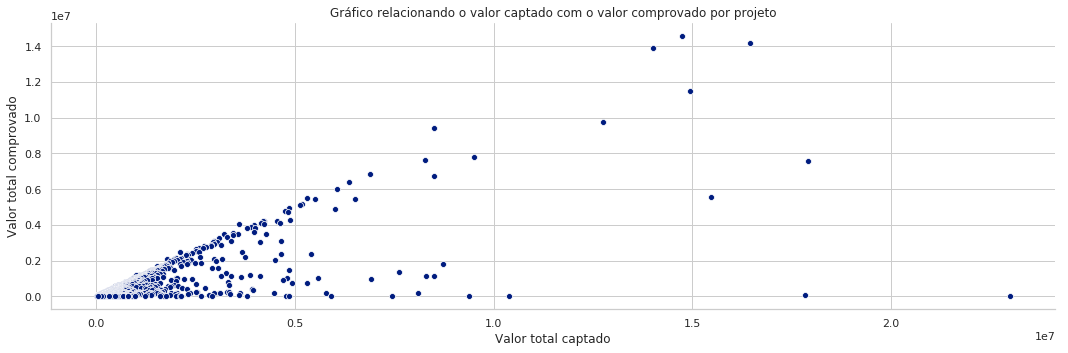

In [11]:
sns.set(style='whitegrid', palette='dark')
sns.relplot(x='CaptacaoReal', y='vlComprovacao', data=data, aspect=3)
plt.xlabel('Valor total captado')
plt.ylabel('Valor total comprovado')
plt.title('Gráfico relacionando o valor captado com o valor comprovado por projeto');

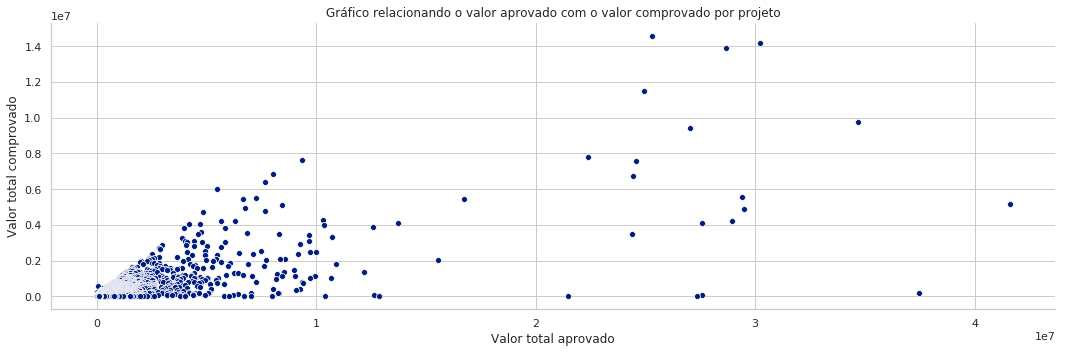

In [12]:
sns.set(style='whitegrid', palette='dark')
sns.relplot(x='VlTotalAprovado', y='vlComprovacao', data=data, aspect=3)
plt.xlabel('Valor total aprovado')
plt.ylabel('Valor total comprovado')
plt.title('Gráfico relacionando o valor aprovado com o valor comprovado por projeto');

Média da distribuição: 0.81
Desvio padrão da distribuição: 0.32



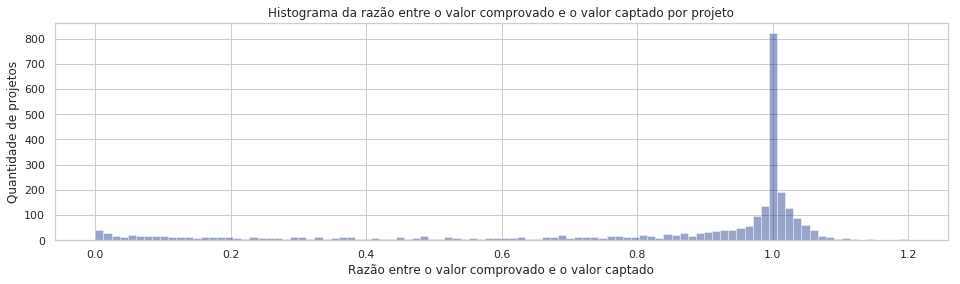

In [13]:
sns.set(style='whitegrid', palette='dark')
f, ax = plt.subplots(figsize=(16,4))

sns.distplot(projects, bins=100, kde=False)
plt.title('Histograma da razão entre o valor comprovado e o valor captado por projeto')
plt.ylabel('Quantidade de projetos')
plt.xlabel('Razão entre o valor comprovado e o valor captado')
plt.grid(True)

expected_mean = np.mean(projects)
expected_std = np.std(projects)

print('Média da distribuição: %.2lf' % expected_mean)
print('Desvio padrão da distribuição: %.2lf\n' % expected_std)

#### Separando os conjuntos de treino e teste

In [14]:
from sklearn.model_selection import train_test_split
projects_train, projects_test = train_test_split(projects, test_size=0.3)

display(projects_train.head())
display(projects_test.head())

1413910    0.983053
154966     0.910120
163340     0.763806
137793     0.005164
171197     1.000000
Name: provenRaisedRatio, dtype: float64

1411526    0.998739
1414338    0.964491
152984     1.000104
128843     0.996389
1413032    0.982044
Name: provenRaisedRatio, dtype: float64

#### Implementando função auxiliar para mostrar os gráficos e estatísticas referentes a cada um dos modelos explorados

In [15]:
import time
def show_stats(model, train_set, test_set, bin_size=1):
    begin = time.time()
    model.fit(train_set)
    print('Tempo de treinamento: %.3lf (s)' % (time.time() - begin))
    begin = time.time()
    is_inlier = model.predict(test_set)
    print('Tempo de teste: %.3lf (s)' % (time.time() - begin))

    contamination_found = sum(~is_inlier) / len(test_set)
    print('Percentual de outliers esperado: %.2lf%%' % (100 * model.contamination))
    print('Percentual de outliers encontrado: %.2lf%%' % (100 * contamination_found))

    sns.set(style='whitegrid', palette='dark')
    f, ax = plt.subplots(figsize=(16,4))

    inliers = test_set[is_inlier]
    bins = max(1, int((max(inliers) - min(inliers)) // bin_size) + 1)
    sns.distplot(inliers, label='inliers', color='b', kde=False, bins=bins)

    outliers = test_set[~is_inlier]
    bins = max(1, int((max(outliers) - min(outliers)) // bin_size) + 1)
    sns.distplot(outliers, label='outliers', color='r', kde=False, bins=bins)
    
    if hasattr(model.model, 'pdf'):
        x = np.linspace(min(test_set), max(test_set), 1000)
        y = model.model.pdf(x)
        if hasattr(model, 'transform'):
            y = model.model.pdf(model.transform(x))
        plt.plot(x,  bin_size * len(test_set) * y, label='PDF')

    plt.legend(frameon=True)
    plt.ylabel('# projects')
    plt.xlabel('verified and raised funds ratio')
    plt.title('Inlier/Outlier division')

#### Implementando funções auxiliares para os modelos utilizados

In [16]:
def bisect(f, a=0, b=1, rtol=1e-6, maxiter=40):
    # simplified scipy.optimize.bisect
    niter, x0 = (0, a)
    while niter < maxiter:
        niter += 1
        x0 = (b + a) / 2
        f0 = f(x0)
        if abs(f0) < rtol:
            break
        elif f0 < 0:
            b = x0
        else:
            a = x0
    return x0

def find_threshold(model, X, contamination):
    h = max(X) - min(X)
    _X = np.linspace(min(X) - h, max(X) + h, int(1e3))
    dx = _X[1] - _X[0]
    pdf = model.pdf(_X)
    def f(threshold):
        _pdf = pdf.copy()
        _pdf[_pdf <= threshold] = 0
        I = scipy.integrate.simps(_pdf, dx=dx)
        return I - (1.0 - contamination)
    return bisect(f)

#### Modelo Gaussiano

Tempo de treinamento: 0.027 (s)
Tempo de teste: 0.002 (s)
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 12.95%


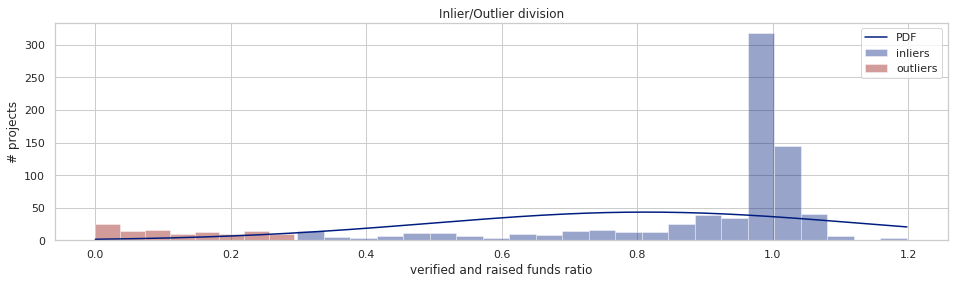

In [17]:
class Gaussian:
    def __init__(self, contamination=0.1):
        self.contamination = contamination

    def fit(self, X):
        # Generate model
        mean, std = scipy.stats.norm.fit(X)
        self.model = scipy.stats.norm(mean, std)
        # Find threshold
        self.threshold = find_threshold(self.model, X, self.contamination)
        return self
    
    def predict(self, X):
        is_inlier = (self.model.pdf(X) > self.threshold)
        return is_inlier

show_stats(Gaussian(), projects_train, projects_test, bin_size=0.04)

#### Modelo Log-normal

Tempo de treinamento: 0.171 (s)
Tempo de teste: 0.005 (s)
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 17.27%


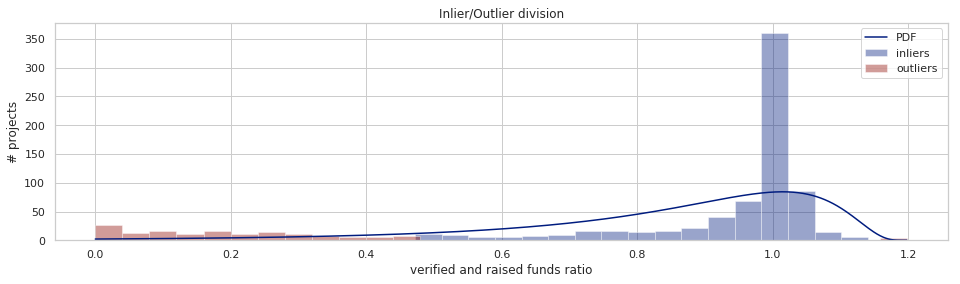

In [18]:
class Lognormal:
    def __init__(self, contamination=0.1, transform=lambda X: X):
        self.contamination = contamination
        self.transform = transform

    def fit(self, X):
        # Generate model
        X = self.transform(X)
        s, loc, scale = scipy.stats.lognorm.fit(X, floc=0)
        self.model = scipy.stats.lognorm(np.std(np.log(X)), loc=loc, scale=scale)
        # Find threshold
        self.threshold = find_threshold(self.model, X, self.contamination)
        return self
    
    def predict(self, X):
        X = self.transform(X)
        is_inlier = (self.model.pdf(X) > self.threshold)
        return is_inlier

show_stats(Lognormal(transform=lambda X: 1.2-X), projects_train, projects_test, bin_size=0.04)

#### Modelo Gamma

Tempo de treinamento: 0.024 (s)
Tempo de teste: 0.003 (s)
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 3.62%


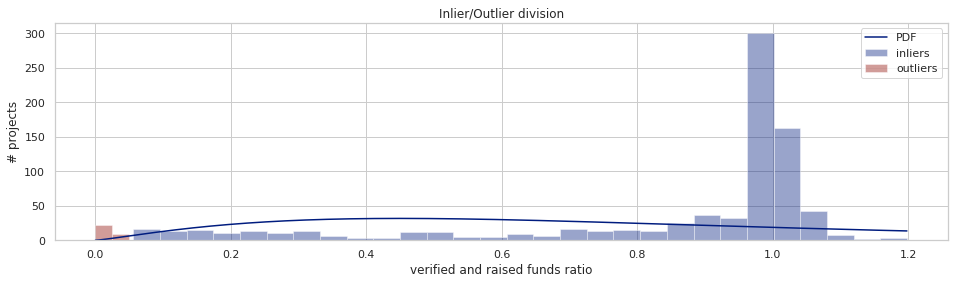

In [19]:
class Gamma:
    def __init__(self, contamination=0.1):
        self.contamination = contamination

    def fit(self, X):
        # Generate model
        params = scipy.stats.gamma.fit(X, floc=0)
        self.model = scipy.stats.gamma(*params)
        # Find threshold
        self.threshold = find_threshold(self.model, X, self.contamination)
        return self
    
    def predict(self, X):
        is_inlier = (self.model.pdf(X) > self.threshold)
        return is_inlier
    
show_stats(Gamma(), projects_train, projects_test, bin_size=0.04)

#### Modelo de Estimativa de Densidade Kernel com Kernel Gaussiano

Tempo de treinamento: 0.242 (s)
Tempo de teste: 0.188 (s)
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 7.00%


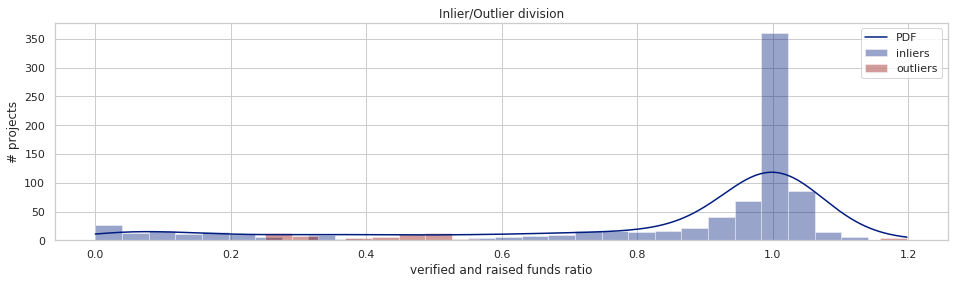

In [20]:
class KDE:
    def __init__(self, contamination=0.1, kernel='gauss'):
        self.contamination = contamination
        self.kernel = kernel

    def fit(self, X):
        # Generate model
        if self.kernel == 'gauss':
            self.model = scipy.stats.gaussian_kde(X)
        else:
            raise AttributeError('Kernel function not found')
        # Find threshold
        self.threshold = find_threshold(self.model, X, self.contamination)
        return self
    
    def predict(self, X):
        is_inlier = (self.model.pdf(X) > self.threshold)
        return is_inlier

show_stats(KDE(), projects_train, projects_test, bin_size=0.04)

#### Estimador por Fator de Anomalia Local (LOF)

Tempo de treinamento: 0.143 (s)
Tempo de teste: 0.009 (s)
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 21.00%


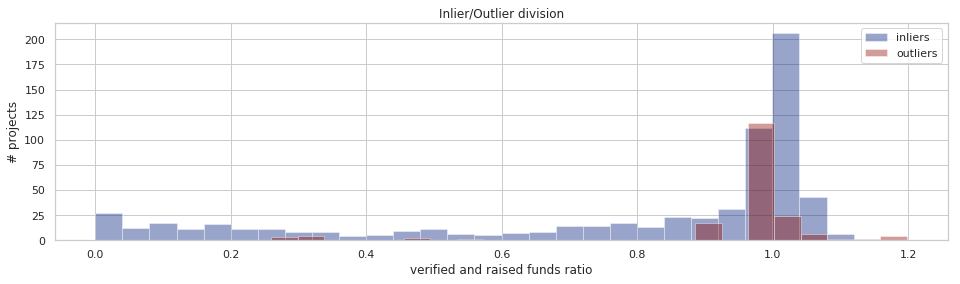

In [21]:
from sklearn.neighbors import LocalOutlierFactor
class LOF:
    def __init__(self, contamination=0.1, n_neighbors=None):
        self.contamination = contamination
        self.n_neighbors = n_neighbors

    def fit(self, X):
        # Transform data into a 2D array
        X = self._1Dto2D(X)
        # Get inliers of the training set with LOF Outlier Detection
        if self.n_neighbors == None:
            self.n_neighbors = len(X) // 10
        lof_OD = LocalOutlierFactor(contamination=self.contamination,
                                    n_neighbors=self.n_neighbors)
        y = lof_OD.fit_predict(X)
        X = X[y == 1, :]
        # Train model with LOF Novelty Detection, using train set inliers
        # Parameter 'contamination' does not matter at this point
        self.model = LocalOutlierFactor(novelty=True, contamination=self.contamination)
        self.model = self.model.fit(X)
        return self
    
    def predict(self, X):
        X = self._1Dto2D(X)
        is_inlier = (self.model.predict(X) == 1)
        return is_inlier
    
    def _1Dto2D(self, X):
        shape = (len(X),1)
        return np.hstack([np.array(X.tolist()).reshape(shape), np.zeros(shape)])

show_stats(LOF(), projects_train, projects_test, bin_size=0.04)

#### Avaliando a contaminação média encontrada

Nesta seção, os diversos modelos implementados acima são aplicados a várias escolhas aleatórias de conjuntos de treino/teste. Ao final, o desempenho de cada modelo é avaliado.

In [22]:
models = [{
    'name': 'Gaussian',
    'curve': Gaussian(),
    'results': []
},{
    'name': 'Log-normal',
    'curve': Lognormal(transform=lambda X: 1.2-X),
    'results': []
},{
    'name': 'Gamma',
    'curve': Gamma(),
    'results': []
},{
    'name': 'KDE-Gauss',
    'curve': KDE(),
    'results': []
},{
    'name': 'LOF',
    'curve': LOF(),
    'results': []
}]

for i in range(100):
    # Separate train and test sets
    projects_train, projects_test = train_test_split(projects, test_size=0.3)
    
    # Get results for each model
    for model in models:
        inlier_filter = (model['curve'].fit(projects_train).predict(projects_test))
        contamination_found = sum(~inlier_filter) / len(projects_test)
        model['results'].append(100 * contamination_found)

Média Gaussian: 12.47%
Média Log-normal: 17.49%
Média Gamma: 3.96%
Média KDE-Gauss: 7.66%
Média LOF: 20.09%


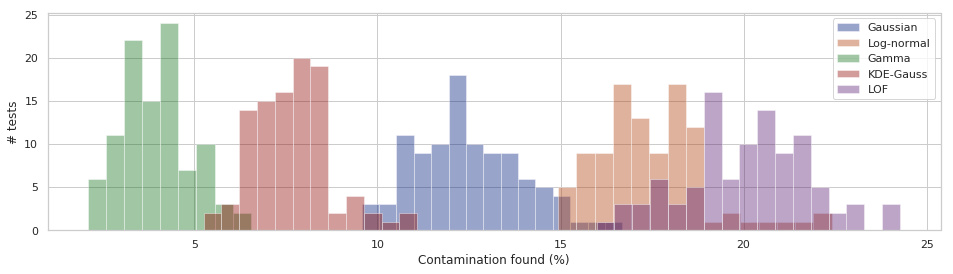

In [23]:
sns.set(style='whitegrid', palette='dark')
f, ax = plt.subplots(figsize=(16,4))

bin_size = 0.5
for model in models:
    results = model['results']
    print('Média %s: %.2lf%%' % (model['name'], np.mean(results)))
    bins = max(1, int((max(results) - min(results)) // bin_size) + 1)
    sns.distplot(results, label=model['name'], kde=False, bins=bins)

plt.legend(frameon=True)
plt.xlabel('Contamination found (%)')
plt.ylabel('# tests')
plt.grid(True)

---
## Resultados e Conclusões

Os modelos de Distribuição Gaussiana e KDE apresentaram os melhores resultados em termos de acurácia, contudo, o KDE é muito mais lento, devido a sua complexidade. Os modelos Gaussiano e Log-Normal apresentaram os melhores resultados em termos de desempenho, sendo o modelo de distribuição Gaussiana a opção mais adequadas ao contexto. O KDE apresentou resultados bons, contudo, obteve um desempenho ruim, chegando a ser 10 vezes mais lento que o Gaussiano na etapa de treinamento e 100 vezes mais lento na etapa de teste.

O modelo Gamma apresentou uma taxa média de contaminação muito baixa e assim, não é adequado para o contexto. O modelo LOF apresentou uma taxa de contaminação muito elevada e rotulou valores altos de "razão de valor comprovado por valor captado" como outliers, o que não parece fazer sentido para o contexto.